In [57]:
!pip install squarify

Importing all the necessary packages for the notebook

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plotter
import seaborn as plot_sea
import squarify

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

Load folder and files from the google drive

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load dataset from the google drive

In [61]:
base_data=pd.read_csv('drive/MyDrive/AI/fer2013.csv')

# Feature Engineering and Data Preprocessing

In [62]:
# get the last five row from the dataset
base_data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [63]:
# get the first five row from the dataset
base_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [64]:
# get the detail and statistics of the numerical columns present in the dataset
base_data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [65]:
# get the total count of emotions in the dataset
base_data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [66]:
# get the total count of Usage column's data
base_data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [67]:
# display general information of the dataset which includes counts of null value and datatypes
base_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [68]:
# count null value if exists
base_data.isnull().value_counts()

emotion  pixels  Usage
False    False   False    35887
dtype: int64

**normalizer()** function normalize the column in the dataset and perform one hot encode which convert all the numerical value between 0 to 1

In [69]:
# convert any numerical value between 0 to 1
def normalizer(d):
    d = np.array(d, 'float32')
    d -= np.mean(d, axis=0)
    d /= np.std(d, axis=0)
    return d

***pixel_to_array()*** function converts pixel value in the row into array

In [70]:
# convert individual pixel data into array
normalized_pixel=[]
def pixel_to_array(dataset):
    for index, row in dataset.iterrows():
        pixels = row['pixels'].split(' ')
        normalized_pixel.append(np.array(pixels).astype('float32'))
    return normalized_pixel

In [71]:
# create new column normalized_pixels and add pixel array data
base_data['normalized_pixels']=pixel_to_array(base_data)

In [72]:
base_data.head()

,emotion,pixels,Usage,normalized_pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [73]:
trainDataX, trainDataY, validationDataX, validatioDataY, testDataX, testDataY = [],[],[],[],[],[]

***trainTestValidationSplit()*** function split dataset provided into training, testing and validation data from the Usage column of dataset

In [74]:
def trainTestValidationSplit(dataset):
    for i, single_row_data in dataset.iterrows():
        
        if 'Training' in single_row_data['Usage']:
            trainDataX.append(np.array(single_row_data['normalized_pixels']).astype('float32'))
            trainDataY.append(single_row_data['emotion'])
        elif 'PublicTest' in single_row_data['Usage']:
            validationDataX.append(np.array(single_row_data['normalized_pixels']).astype('float32'))
            validatioDataY.append(single_row_data['emotion'])
        elif 'PrivateTest' in single_row_data['Usage']:
            testDataX.append(np.array(single_row_data['normalized_pixels']).astype('float32'))
            testDataY.append(single_row_data['emotion'])
    
    return trainDataX, trainDataY, validationDataX, validatioDataY, testDataX, testDataY

In [75]:
trainDataX, trainDataY, validationDataX, validatioDataY, testDataX, testDataY=trainTestValidationSplit(base_data)

In [76]:
# add normalize data into splited data
trainDataX=normalizer(trainDataX)
validationDataX=normalizer(validationDataX)
testDataX=normalizer(testDataX)

In [77]:
validationDataX[0]

array([ 1.6505896 ,  1.7122597 ,  1.774942  , ..., -0.9225547 ,
        0.18117245,  0.80417955], dtype=float32)

In [78]:
# Reshape the training, testing and validation dataset 
trainDataX = trainDataX.reshape(trainDataX.shape[0],48,48,1)
validationDataX = validationDataX.reshape(validationDataX.shape[0],48,48,1)
testDataX = testDataX.reshape(testDataX.shape[0],48,48,1)
trainDataY = np_utils.to_categorical(trainDataY, num_classes=7)
validatioDataY = np_utils.to_categorical(validatioDataY, num_classes=7)

In [79]:
base_data.head()

,emotion,pixels,Usage,normalized_pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


***convert_emotion()*** function returns the label text according to the emotion numerical data

In [80]:
def convert_emotion(single_row_data):  
    if single_row_data['emotion'] == 0:
      return 'Angry'
    elif single_row_data['emotion'] == 1:
        return 'Disgust'
    elif single_row_data['emotion'] == 2:
        return 'Scared'
    elif single_row_data['emotion'] == 3:
        return 'Happy'
    elif single_row_data['emotion'] == 4:
        return 'Sad'
    elif single_row_data['emotion'] == 5:
        return 'Surprised'
    elif single_row_data['emotion'] == 6:
        return 'Neutral'
    return 'None'

In [81]:
#create new column as text_emotion and add data from numerical emotion to text
base_data['text_emotion'] = base_data.apply(lambda row: convert_emotion(row), axis=1)

In [82]:
base_data.head()

,emotion,pixels,Usage,normalized_pixels,text_emotion
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Angry
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Angry
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Scared
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Sad
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Neutral


In [83]:
base_data.tail()

,emotion,pixels,Usage,normalized_pixels,text_emotion
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest,"[50.0, 36.0, 17.0, 22.0, 23.0, 29.0, 33.0, 39....",Neutral
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest,"[178.0, 174.0, 172.0, 173.0, 181.0, 188.0, 191...",Happy
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest,"[17.0, 17.0, 16.0, 23.0, 28.0, 22.0, 19.0, 17....",Angry
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest,"[30.0, 28.0, 28.0, 29.0, 31.0, 30.0, 42.0, 68....",Happy
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest,"[19.0, 13.0, 14.0, 12.0, 13.0, 16.0, 21.0, 33....",Scared


In [84]:
base_data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [85]:
base_data['text_emotion'].value_counts()

Happy        8989
Neutral      6198
Sad          6077
Scared       5121
Angry        4953
Surprised    4002
Disgust       547
Name: text_emotion, dtype: int64

# Data Visualization

## Bar Graph representing the emotions and their count


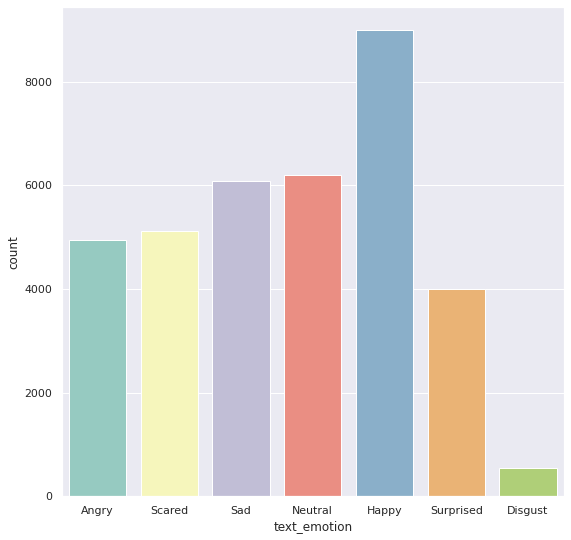

In [86]:
plotting_figures=plotter.figure(figsize = (9,9))
plot_sea.countplot(x='text_emotion', data = base_data, palette = 'Set3')
plotting_figures.savefig('EmotionCount.png')
plotting_figures.savefig('drive/MyDrive/AI/EmotionCount.png')

## Bar Graph representing the Usage column with the count of emotions

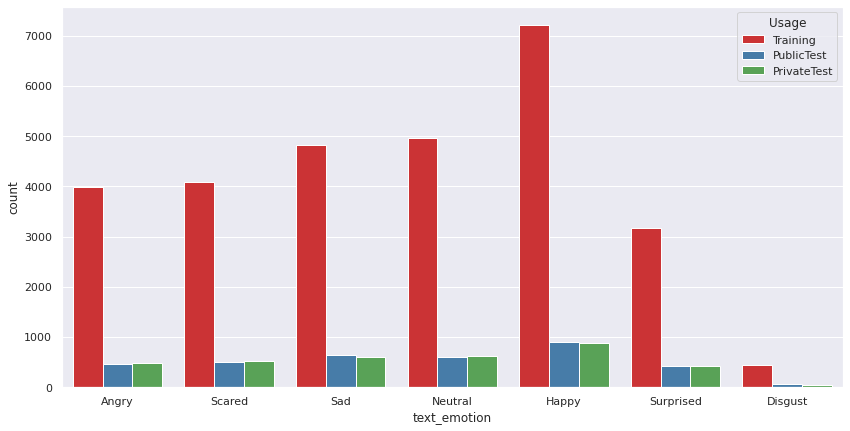

In [87]:
plotting_figures=plotter.figure(figsize = (14,7))
plot_sea.countplot(x='text_emotion',hue="Usage", data=base_data, palette='Set1')
plotting_figures.savefig('DataSplits.png')
plotting_figures.savefig('drive/MyDrive/AI/DataSplits.png')

Checking Correlation in the dataset between columns

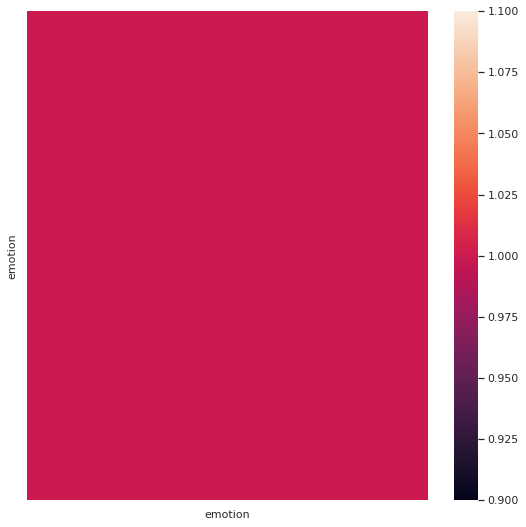

In [88]:
plotting_figures=plotter.figure(figsize = (9,9))
plot_sea.heatmap(base_data.corr())
plotting_figures.savefig('EmotionCountTwo.png')
plotting_figures.savefig('drive/MyDrive/AI/EmotionCountTwo.png')

## Treemap to display the different type of data divided for usage in the model

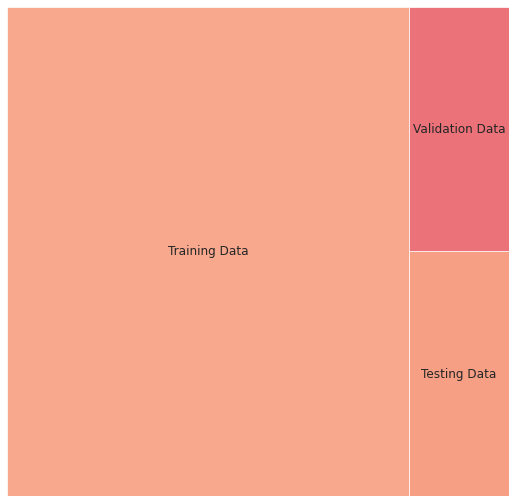

In [89]:
plotting_figures=plotter.figure(figsize = (9,9))
squarify.plot(sizes=base_data['Usage'].value_counts(), label=['Training Data','Testing Data','Validation Data'], alpha=.7)
plotter.axis('off')
plotter.show()
plotting_figures.savefig('DataSplitTwo.png')
plotting_figures.savefig('drive/MyDrive/AI/DataSplitTwo.png')

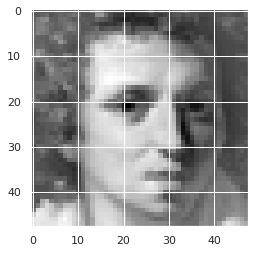

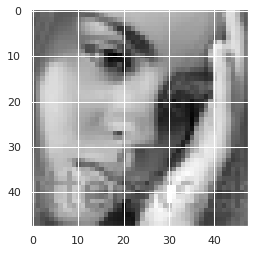

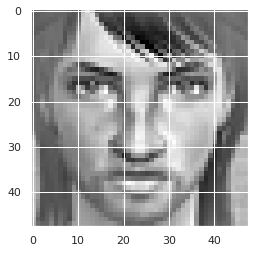

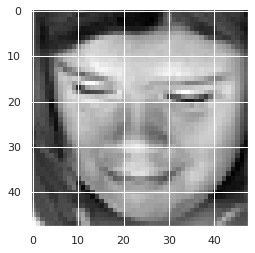

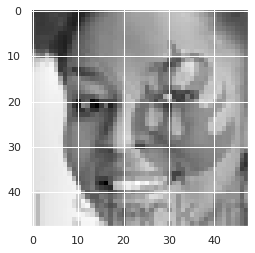

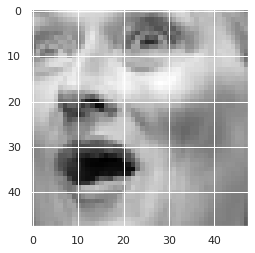

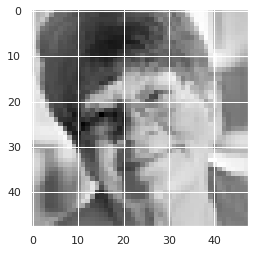

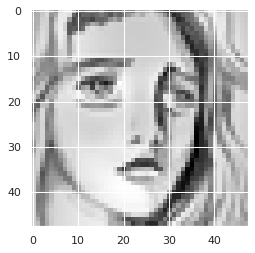

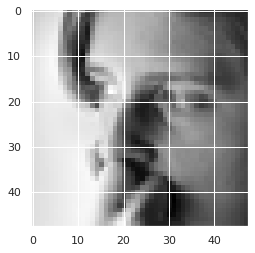

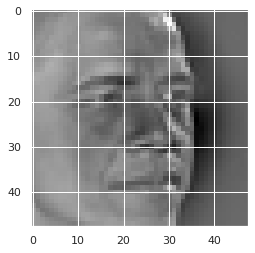

In [90]:
# convert and display images from the pixels from the dataset
for i in range(1000,1010):
  plotter.imshow(trainDataX[i].reshape(48,48), cmap=plotter.cm.gray)
  plotter.show()

***pixel_to_image()*** function converts arrayed pixel to image by plotting them as graph

In [91]:
def pixel_to_image (arrayOfImage, r=1, c=5, figsize=(16,16)):
    plotting_figures = plotter.figure(figsize=(15,15))
    for i in range(0, (r*c)):
        image_of_face = arrayOfImage[i:(i+1),:,:,:]

        display_face_image = plotting_figures.add_subplot(r,c,i+1)
        display_face_image.imshow(image_of_face[0,:,:,0], cmap=plotter.cm.gray)

        plotter.xticks(np.array([]))
        plotter.yticks(np.array([]))
        plotter.tight_layout()
    plotter.show()

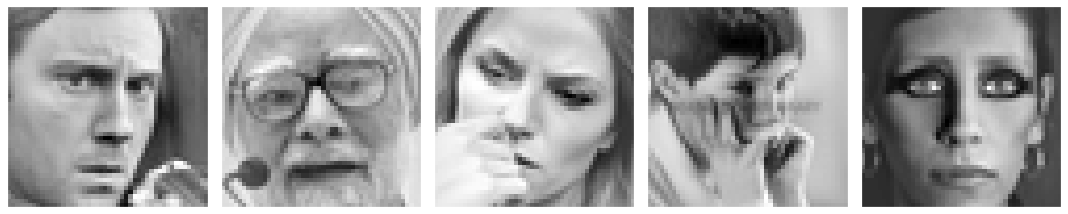

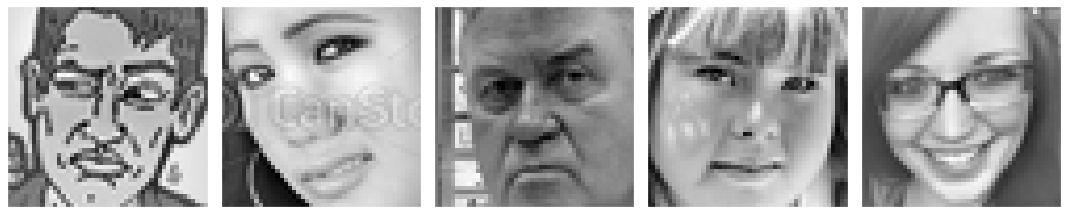

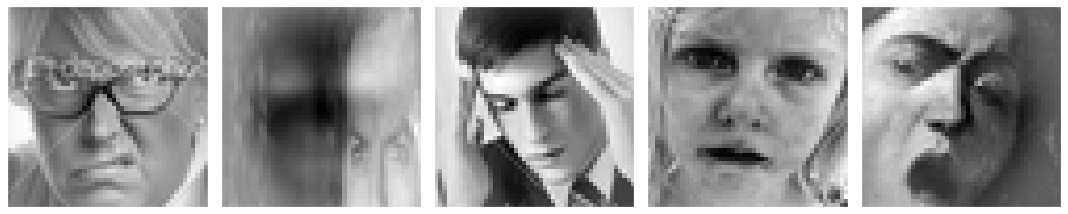

In [92]:
pixel_to_image(trainDataX)
pixel_to_image(validationDataX) 
pixel_to_image(testDataX)

# Deep Convolution Neural Network Model Creation

In [37]:
def deep_neural_network_creator(optimizerOfNeuralNetwork):
    activation_function='elu'
    filter_one=64
    filter_two=128
    filter_three=256
    cnnLayer = Sequential(name='DCNN')

    cnnLayer.add(
        Conv2D(
            filters=filter_one,
            kernel_size=(5,5),
            input_shape=(trainDataX.shape[1], trainDataX.shape[2], trainDataX.shape[3]),
            activation=activation_function,
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    cnnLayer.add(BatchNormalization(name='batchnorm_1'))
    cnnLayer.add(
        Conv2D(
            filters=filter_one,
            kernel_size=(5,5),
            activation=activation_function,
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    cnnLayer.add(BatchNormalization(name='batchnorm_2'))
    
    cnnLayer.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    cnnLayer.add(Dropout(0.4, name='dropout_1'))

    cnnLayer.add(
        Conv2D(
            filters=filter_two,
            kernel_size=(3,3),
            activation=activation_function,
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    cnnLayer.add(BatchNormalization(name='batchnorm_3'))
    cnnLayer.add(
        Conv2D(
            filters=filter_two,
            kernel_size=(3,3),
            activation=activation_function,
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )   
    )
    cnnLayer.add(BatchNormalization(name='batchnorm_4'))
    
    cnnLayer.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    cnnLayer.add(Dropout(0.4, name='dropout_2'))

    cnnLayer.add(
        Conv2D(
            filters=filter_three,
            kernel_size=(3,3),
            activation=activation_function,
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    cnnLayer.add(BatchNormalization(name='batchnorm_5'))
    cnnLayer.add(
        Conv2D(
            filters=filter_three,
            kernel_size=(3,3),
            activation=activation_function,
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    cnnLayer.add(BatchNormalization(name='batchnorm_6'))
    
    cnnLayer.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    cnnLayer.add(Dropout(0.5, name='dropout_3'))

    cnnLayer.add(Flatten(name='flatten'))
        
    cnnLayer.add(
        Dense(
            128,
            activation=activation_function,
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    cnnLayer.add(BatchNormalization(name='batchnorm_7'))
    
    cnnLayer.add(Dropout(0.6, name='dropout_4'))
    
    cnnLayer.add(
        Dense(
            trainDataY.shape[1],
            activation='softmax',
            name='out_layer'
        )
    )
    
    cnnLayer.compile(
        loss='categorical_crossentropy',
        optimizer=optimizerOfNeuralNetwork,
        metrics=['accuracy']
    )
    
    cnnLayer.summary()
    
    return cnnLayer

In [38]:

pat=11
ver=1
mon='val_accuracy'
stopErlyImprov = EarlyStopping(
    monitor=mon,
    min_delta=0.00005,
    patience=pat,
    verbose=ver,
    restore_best_weights=True,
)

schLr = ReduceLROnPlateau(
    monitor=ver,
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    stopErlyImprov,
    schLr,
]


In [39]:
rr=15
widthShiftRange=0.15
heightShiftRange=0.15
shearRange=0.15
zoomRange=0.15
genData = ImageDataGenerator(
    rotation_range=rr,
    width_shift_range=widthShiftRange,
    height_shift_range=heightShiftRange,
    shear_range=shearRange,
    zoom_range=0.15,
    horizontal_flip=True,
)
genData.fit(trainDataX)

# Fitting the model

In [40]:
from tensorflow.keras import optimizers
optimizerOfNeuralNetwork = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = deep_neural_network_creator(optimizerOfNeuralNetwork[1]) 
model_training_fit = model.fit_generator(
    genData.flow(trainDataX, trainDataY, batch_size=32),
    validation_data=(validationDataX, validatioDataY),
    steps_per_epoch=len(trainDataX) / 32,
    epochs=100,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/100
897/897 [==============================] - 61s 55ms/step - loss: 2.0340 - accuracy: 0.2403 - val_loss: 1.6459 - val_accuracy: 0.3653 - lr: 0.0010
Epoch 2/100
897/897 [==============================] - 48s 54ms/step - loss: 1.6732 - accuracy: 0.3301 - val_loss: 1.5188 - val_accuracy: 0.4191 - lr: 0.0010
Epoch 3/100
897/897 [==============================] - 48s 54ms/step - loss: 1.5185 - accuracy: 0.4062 - val_loss: 1.3538 - val_accuracy: 0.4787 - lr: 0.0010
Epoch 4/100
897/897 [==============================] - 48s 53ms/step - loss: 1.4255 - accuracy: 0.4531 - val_loss: 1.2534 - val_accuracy: 0.5311 - lr: 0.0010
Epoch 5/100
897/897 [==============================] - 48s 53ms/step - loss: 1.3598 - accuracy: 0.4848 - val_loss: 1.3865 - val_accuracy: 0.4909 - lr: 0.0010
Epoch 6/100
897/897 [==============================] - 48s 53ms/step - loss: 1.3054 - accuracy: 0.4997 - val_loss: 1.2180 - val_accuracy: 0.5450 - lr: 0.0010
Epoch 7/100
897/897 [==============================]

Save the model as .h5 for the future purpose of user application

In [41]:
export_model = model.to_json()
with open("modelAI.json", "w") as export:
    export.write(export_model)
    
model.save("modelAI.h5")

 

*   Visualization of loss, validation loss in line graph
*   Visualization of accuracy, validation accuracy in line graph



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

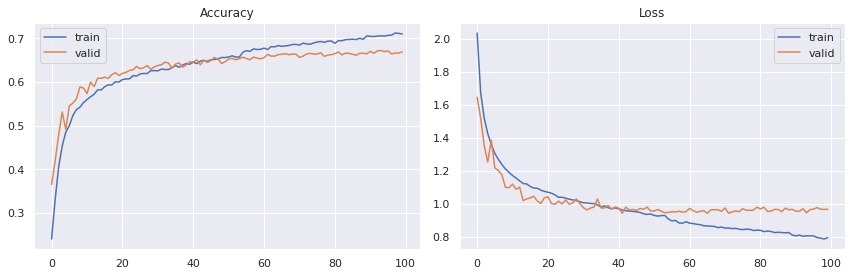

In [42]:
plot_sea.set()
plotting_figures = plotter.figure(0, (12, 4))

axis_of_lot = plotter.subplot(1, 2, 1)
plot_sea.lineplot(model_training_fit.epoch, model_training_fit.model_training_fit['accuracy'], label='training data')
plot_sea.lineplot(model_training_fit.epoch, model_training_fit.model_training_fit['val_accuracy'], label='validation data')
plotter.title('Accuracy')
plotter.tight_layout()

axis_of_lot = plotter.subplot(1, 2, 2)
plot_sea.lineplot(model_training_fit.epoch, model_training_fit.model_training_fit['loss'], label='train data ')
plot_sea.lineplot(model_training_fit.epoch, model_training_fit.model_training_fit['val_loss'], label='validation data')
plotter.title('Loss')
plotter.tight_layout()

plotter.savefig('accuracyAndLoss.png')
plotter.show()

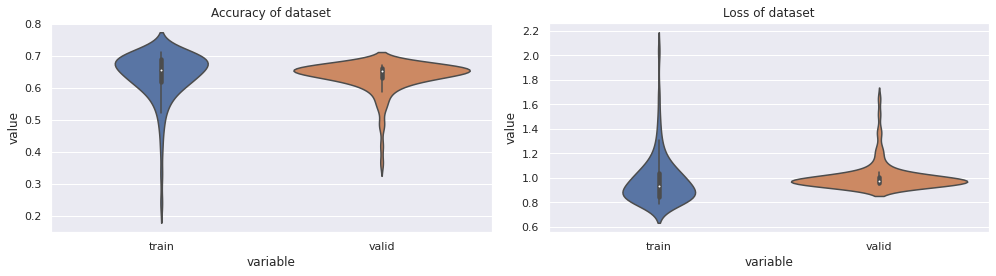

In [44]:
accuracy_of_base_data = pd.DataFrame({'train': model_training_fit.model_training_fit['accuracy'], 'valid': model_training_fit.model_training_fit['val_accuracy']})
loss_of_base_data = pd.DataFrame({'train': model_training_fit.model_training_fit['loss'], 'valid': model_training_fit.model_training_fit['val_loss']})

figure_plot = plotter.figure(0, (14, 4))
axix_of_plot = plotter.subplot(1, 2, 1)
plot_sea.violinplot(x="set", y="value", data=pd.melt(accuracy_of_base_data), showfliers=False)
plotter.title('Accuracy of dataset')
plotter.tight_layout()

axix_of_plot = plotter.subplot(1, 2, 2)
plot_sea.violinplot(x="set", y="value", data=pd.melt(loss_of_base_data), showfliers=False)
plotter.title('Loss of dataset')
plotter.tight_layout()

plotter.savefig('performanceChart.png')
plotter.show()

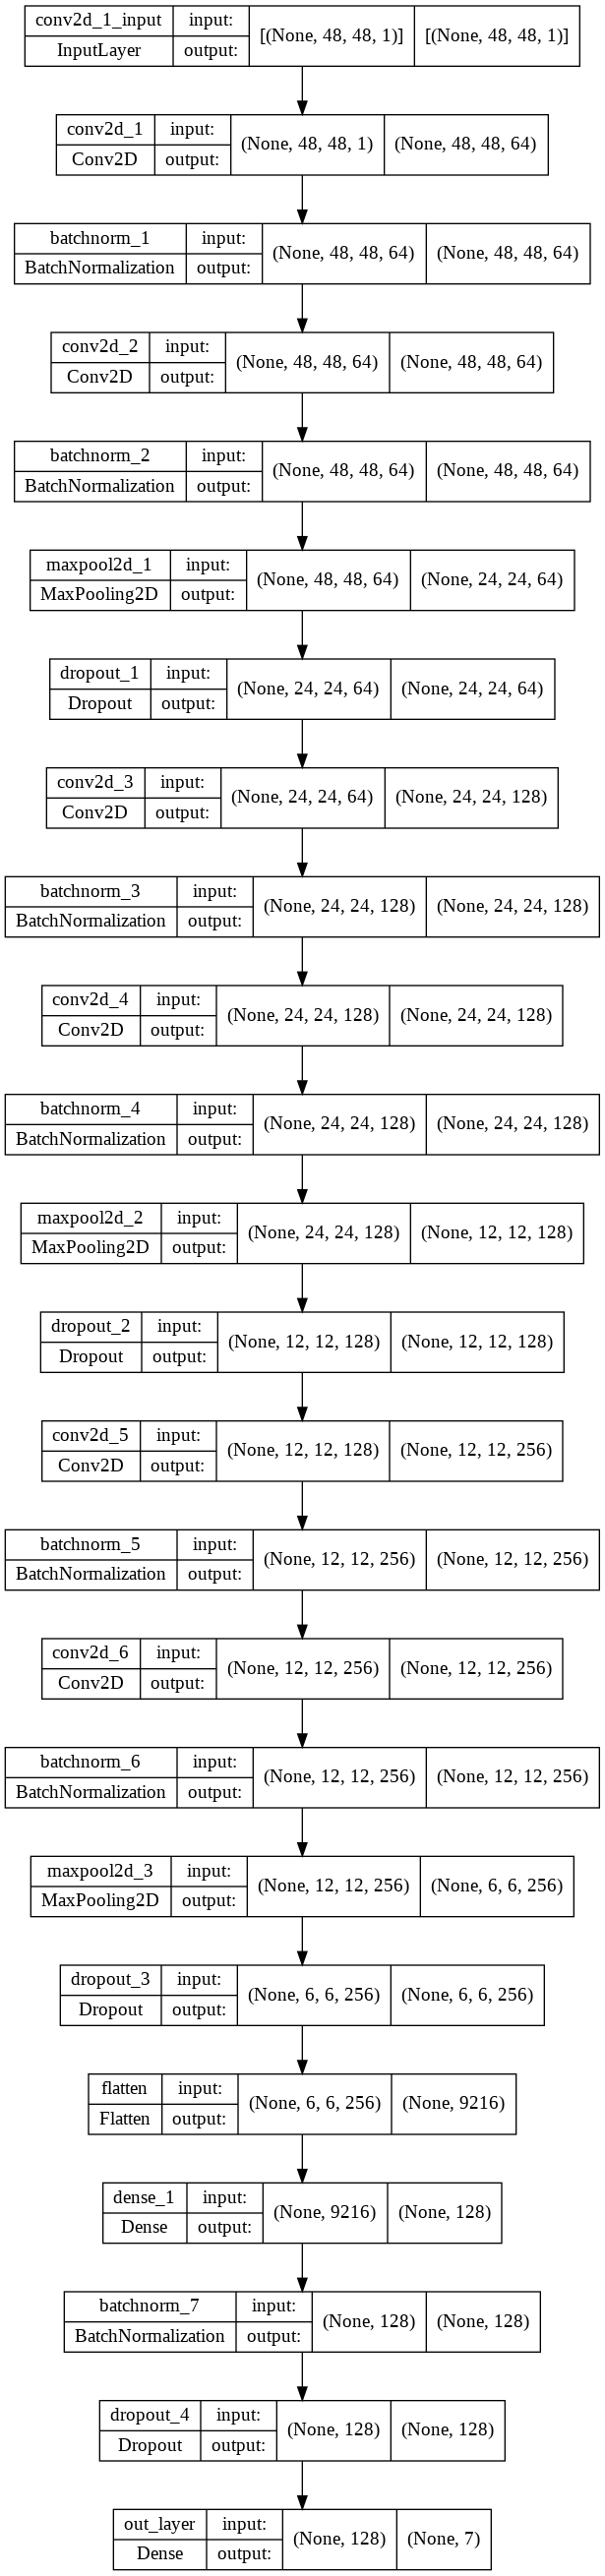

In [45]:
plot_model(model,to_file="PlotedModel.png", show_shapes=True,show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False)

In [46]:

model_training_log ='drive/MyDrive/AI/TrainingLog.log'

log_to_csv = CSVLogger(model_training_log, append=False)

stopTrainingAfterImprov= EarlyStopping(patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduceLearningRate = ReduceLROnPlateau(factor=0.2,
                              patience=10,
                              verbose=1
                              )

callbacks = [log_to_csv, stopTrainingAfterImprov,reduceLearningRate]

In [47]:
log=pd.read_csv('drive/MyDrive/AI/TrainingLog.log')

In [48]:
# display details of the log created
log.describe()

,epoch,accuracy,loss,val_accuracy,val_loss
count,11.000000,11.000000,11.000000,11.000000,11.000000
mean,5.000000,0.718770,0.754107,0.665620,0.936535
std,3.316625,0.002058,0.004047,0.001118,0.003149
min,0.000000,0.715211,0.748502,0.663695,0.930280
25%,2.500000,0.717545,0.751498,0.664809,0.935067
50%,5.000000,0.717824,0.754103,0.665645,0.936972
75%,7.500000,0.720419,0.756298,0.666342,0.938678
max,10.000000,0.722178,0.762774,0.667317,0.941226


In [49]:
log.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.715211,0.762774,0.663695,0.930280
1,1,0.720366,0.756042,0.664531,0.932929
2,2,0.717719,0.756918,0.665924,0.934758
3,3,0.717336,0.756553,0.665366,0.941226
4,4,0.717580,0.755312,0.667038,0.938657


# Testing Model

In [50]:

model.evaluate(testDataX, np_utils.to_categorical(testDataY, num_classes=7))

113/113 [==============================] - 2s 19ms/step - loss: 0.8639 - accuracy: 0.6991


[0.8638784289360046, 0.6990805268287659]

# Predict test data with the help of model

In [51]:
finalPrediction = model.predict(testDataX).argmax(axis=1)

## Confusion matrix for the summary of the prediction done

In [52]:
confusion_matrix_evaluator = confusion_matrix(testDataY, finalPrediction)

# Heatmap visualising the confusion matrix

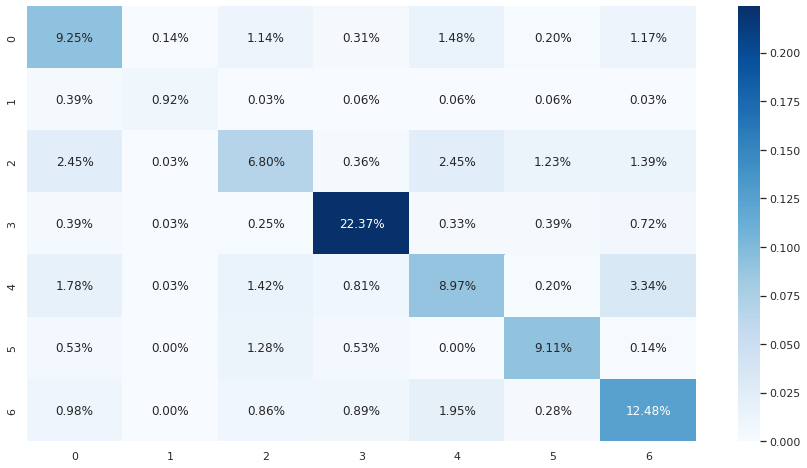

In [53]:
figure_plot=plotter.figure(figsize = (15,8))
plot_sea.heatmap(confusion_matrix_evaluator/np.sum(confusion_matrix_evaluator), cmap='Blues', annot=True, fmt='0.2%')
figure_plot.savefig('drive/MyDrive/AI/prediction.png')

In [54]:
all_expression = ["Angry","Disgust","Scared", "Happy", "Sad", "Surprised","Neutral"]

***model_test()*** function tests the model from the data given from the normalized_pixels

In [55]:
def tester(pixel_img_row):
  img = testDataX[pixel_img_row].reshape(48,48)
  print(testDataX[pixel_img_row])
  plotter.imshow(img, cmap=plotter.cm.gray)
  print("Actual Output: ", all_expression[testDataY[pixel_img_row]])
  print("Prediction Output: ", all_expression[finalPrediction[pixel_img_row]])
  

[[[-1.0922071 ]
  [-0.9907113 ]
  [-0.85948724]
  ...
  [-0.6302266 ]
  [-0.62623   ]
  [-0.6396783 ]]

 [[-0.9817143 ]
  [-0.9111241 ]
  [-0.9405387 ]
  ...
  [-0.42831343]
  [-0.39312205]
  [-0.37384152]]

 [[-0.85770947]
  [-0.8528974 ]
  [-0.8350447 ]
  ...
  [-0.45367372]
  [-0.38212162]
  [-0.43629003]]

 ...

 [[ 1.5162969 ]
  [ 1.7306696 ]
  [ 1.2491555 ]
  ...
  [ 0.13301766]
  [ 0.95324534]
  [ 1.6488491 ]]

 [[ 1.6600448 ]
  [ 1.7363871 ]
  [ 1.6008804 ]
  ...
  [-0.22586879]
  [ 0.3696994 ]
  [ 0.807167  ]]

 [[ 1.6620831 ]
  [ 1.7144854 ]
  [ 1.7434003 ]
  ...
  [-0.600655  ]
  [ 0.43574274]
  [ 0.6181743 ]]]
Actual Output:  neutral
Prediction Output:  neutral


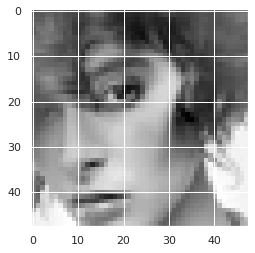

In [56]:
tester(771)

[[[ 1.412526  ]
  [ 1.4814628 ]
  [ 1.5520632 ]
  ...
  [-0.26819748]
  [-0.08595613]
  [ 0.07369903]]

 [[ 1.4377253 ]
  [ 1.5076247 ]
  [ 1.5769277 ]
  ...
  [-0.22750622]
  [-0.18261902]
  [ 0.10006602]]

 [[ 1.4529188 ]
  [ 1.5403777 ]
  [ 1.599241  ]
  ...
  [-0.25097576]
  [-0.2078226 ]
  [-0.07043845]]

 ...

 [[ 1.2790534 ]
  [ 1.0642484 ]
  [ 0.21290325]
  ...
  [ 0.15860112]
  [ 0.24228914]
  [ 0.11030512]]

 [[ 1.2719382 ]
  [ 1.2164794 ]
  [ 0.5863464 ]
  ...
  [ 0.2239458 ]
  [ 0.26785427]
  [ 0.03511334]]

 [[ 1.2740886 ]
  [ 1.2216512 ]
  [ 0.99809676]
  ...
  [ 0.27137092]
  [ 0.29603118]
  [ 0.02532603]]]
Actual Output:  happy
Prediction Output:  happy


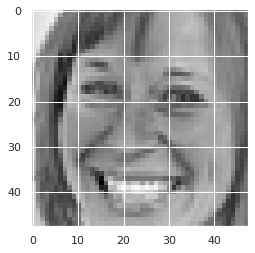

In [96]:
tester(1500)

[[[-0.81524146]
  [-1.01531   ]
  [-1.0855701 ]
  ...
  [ 0.06886414]
  [ 0.35608613]
  [ 0.44852442]]

 [[-0.8601344 ]
  [-1.072374  ]
  [-1.1682492 ]
  ...
  [ 0.22431001]
  [ 0.17647442]
  [ 0.53751916]]

 [[-0.85770947]
  [-1.1021968 ]
  [-1.2173933 ]
  ...
  [ 0.5851534 ]
  [ 0.20302507]
  [ 0.55150926]]

 ...

 [[ 0.8170531 ]
  [ 0.85049057]
  [ 0.4530105 ]
  ...
  [ 1.3098572 ]
  [ 1.2960278 ]
  [ 1.3083516 ]]

 [[ 0.80871403]
  [ 0.8741011 ]
  [ 0.43416625]
  ...
  [ 1.2520934 ]
  [ 1.2608443 ]
  [ 1.2754618 ]]

 [[ 0.8109983 ]
  [ 0.8551847 ]
  [ 0.39174804]
  ...
  [ 1.1562208 ]
  [ 1.223208  ]
  [ 1.2110225 ]]]
Actual Output:  neutral
Prediction Output:  neutral


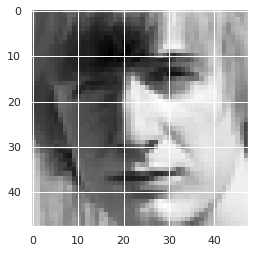

In [97]:
tester(2001)

[[[-0.0445543 ]
  [ 0.03013671]
  [-0.06819726]
  ...
  [-0.54284024]
  [-0.24558249]
  [ 0.08579017]]

 [[ 1.3890934 ]
  [ 0.55252904]
  [-0.3712624 ]
  ...
  [-0.75462514]
  [-0.45503473]
  [-0.16726644]]

 [[ 0.9638969 ]
  [ 0.14430058]
  [-0.61838055]
  ...
  [-0.5550227 ]
  [-0.65602005]
  [-0.53385043]]

 ...

 [[ 0.64224213]
  [ 0.58643687]
  [ 0.8068527 ]
  ...
  [ 0.2993102 ]
  [ 1.1436801 ]
  [ 1.4975169 ]]

 [[ 0.52076393]
  [ 0.68389094]
  [ 0.7892532 ]
  ...
  [ 0.40387163]
  [ 1.4772652 ]
  [ 1.5792207 ]]

 [[ 0.49809945]
  [ 0.5771757 ]
  [ 0.6064966 ]
  ...
  [ 0.69456   ]
  [ 1.6804459 ]
  [ 1.6020501 ]]]
Actual Output:  angry
Prediction Output:  angry


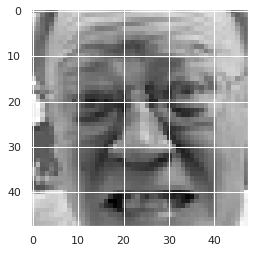

In [101]:
tester(3000)